Aggregate dEBM data to catchment means, based on the processing for GrSMBMIP.  

- Phase 1: 2007-2017 catchment means + monthly lapse rates.  Restrict inflection point elevations to be consistent
- Phase 2: 2010-2205 catchment means

Last updated: 9 Dec 2022 | EHU

In [1]:
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
import shapefile
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pyproj as pyproj
from scipy import interpolate
import datetime
import time

In [2]:
###------------------------
### DATA READ-IN  AND PROJECTION
###------------------------

## Read in BedMachine grid to reproject SMB
gl_bed_path ='/Volumes/GoogleDrive/My Drive/Greenland-data/BedMachine-Greenland/BedMachineGreenland-2017-09-20.nc'
fh = Dataset(gl_bed_path, mode='r')
xx = fh.variables['x'][:].copy() #x-coord (polar stereo (70, 45))
yy = fh.variables['y'][:].copy() #y-coord
ss = fh.variables['surface'][:].copy() # surface elevation
M = fh.variables['mask'][:].copy() ## land cover type mask (2 = grounded ice)
fh.close()

## Read in Mouginot catchments from shapefile
print('Reading in Mouginot catchments')
catchment_fn = '/Volumes/GoogleDrive/My Drive/Greenland-data/Greenland-catchments-Mouginot/Greenland_Basins_PS_v1.4.2.'
sf = shapefile.Reader(catchment_fn) 

Reading in Mouginot catchments


In [3]:
## read in ISMIP6 grid for geometry
print('Reading in ISMIP6 geometry')
geom_path = '/Users/eultee@middlebury.edu/Documents/Research/data/5km_ISMIP6grid.nc'
fh3 = Dataset(geom_path, mode='r')
x_lon_debm = fh3.variables['lon'][:].copy() # longitude
y_lat_debm = fh3.variables['lat'][:].copy() # latitude
fh3.close()

Reading in ISMIP6 geometry


In [21]:
## dEBM read in for preliminary view
print('Reading in example dEBM field')
debm_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_2007.nc'
fh2 = Dataset(debm_path, mode='r')
# x_debm = fh2.dimensions['x'].copy() #x-coord (polar stereo?)
# y_debm = fh2.dimensions['y'].copy() #y-coord 
smb_debm = fh2.variables['SMB'][:].copy()
fh2.close()

Reading in example dEBM field


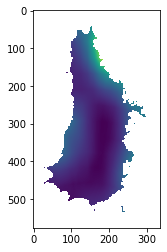

In [25]:
import matplotlib.pyplot as plt
plt.imshow(smb_debm[0])

In [4]:
###------------------------
### SET UP SMB REPROJECTION
###------------------------

## Down-sample bed topo
x_3km = xx[::20] # sample at ~3 km resolution
y_3km = yy[::20]
s_3km = ss[::20,::20] ## we'll use surface elevation for monthly lapse rate
Xmat, Ymat = np.meshgrid(x_3km, y_3km) # Downsampled BedMachine coords

print('Creating reprojected grid')
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by SMB data
psn_gl = pyproj.Proj("+init=epsg:3413") # Polar Stereographic North used by BedMachine and Mankoff
xs, ys = pyproj.transform(wgs84, psn_gl, x_lon_debm, y_lat_debm)

Creating reprojected grid


/Users/eultee@middlebury.edu/opt/miniconda3/envs/stisp/lib/python3.9/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/Users/eultee@middlebury.edu/opt/miniconda3/envs/stisp/lib/python3.9/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/var/folders/9p/tb_5v0h13gn0dkwwjdwn3md80000gp/T/ipykernel_50555/1494661919.py:14: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io

In [38]:
###------------------------
### CHOOSE CATCHMENTS
###------------------------
first_ctmt = 150
last_ctmt = 260 ## confirmed that 260 should be end of the catchments available by running to 300, got error after 259
catchments_to_pull = np.arange(first_ctmt, last_ctmt).tolist()

In [39]:
###------------------------
### CREATE FRAMEWORK
###------------------------

caps_and_disjoint = []

## Perform Delaunay triangulation over each catchment region
tri_ctmts = {i: [] for i in catchments_to_pull}
for i in catchments_to_pull:
    print('Triangulating catchment {}'.format(sf.record(i)['NAME']))
    c = MultiPoint(sf.shape(i).points)
    tris = triangulate(c)
    tri_ctmts[i] = tris
    if 'ICE_CAPS' in sf.record(i)['NAME']:
        caps_and_disjoint.append(i)
    elif len(sf.shape(i).parts)>1:
        caps_and_disjoint.append(i)


years = range(2007,2018) ## calibration period 2007-2017 inclusive
start_date = datetime.datetime(years[0],1,1)
end_date = datetime.datetime(years[-1],12,31)
dates = pd.date_range(start=start_date, end=end_date, freq='M')
df_record = pd.DataFrame(columns=[i for i in catchments_to_pull], index=dates)
df_elev_per_ctmt = {i: 
                    {n: 
                     {y: pd.DataFrame(columns=('elevation', 
                                                     'point_smb')) for y in years} for n in range(12)} for i in catchments_to_pull}

Triangulating catchment KRONBORG
Triangulating catchment BORGGRAVEN
Triangulating catchment SYDBR
Triangulating catchment BREDEGLETSJER
Triangulating catchment GEIKIE2
Triangulating catchment GEIKIE3
Triangulating catchment GEIKIE6
Triangulating catchment DENDRITGLETSCHER
Triangulating catchment SHARP_W
Triangulating catchment HART
Triangulating catchment HART_W
Triangulating catchment HUBBARD
Triangulating catchment GABLE_MIRROR
Triangulating catchment BOWDOIN
Triangulating catchment SUN
Triangulating catchment SUN_W
Triangulating catchment VERHOEFF
Triangulating catchment VERHOEFF_W
Triangulating catchment MEEHAN
Triangulating catchment MEEHAN_W
Triangulating catchment SIORARSUAQ
Triangulating catchment MORRIS_JESUP
Triangulating catchment MORRIS_JESUP_W
Triangulating catchment DIEBITSCH
Triangulating catchment BAMSE
Triangulating catchment DODGE
Triangulating catchment SAVISSUAQ_UNNAMED1
Triangulating catchment SAVISSUAQ_WWWWW
Triangulating catchment SAVISSUAQ_UNNAMED2
Triangulating

In [40]:
caps_and_disjoint

[225, 226, 227, 228, 229, 243, 255, 259]

In [59]:
###------------------------
### CATCHMENT-SUM FOR ALL MODELS
###------------------------

t0 = time.time()
for y in years:
    ti = time.time()
    fpath = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_{}.nc'.format(y)
    fh = Dataset(fpath, mode='r')
    smb_m = fh.variables['SMB'][:].copy()
    fh.close()
    d_subset = [d for d in dates if d.year==y]
    for i in range(len(smb_m)): # for each month
        ## interpolate SMB
        smb_ds = smb_m[i]
        regridded_smb = interpolate.griddata((xs.ravel(), ys.ravel()), smb_ds.ravel(), (Xmat, Ymat), method='nearest')
        ## Sample SMB at each Delaunay triangle and sum
        for j in catchments_to_pull:
            if j in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
                pass
            else:
                catchment_sum = 0
                area_sum = 0
                triangles = tri_ctmts[j]
                for tri in triangles:
                    rep_x, rep_y = tri.representative_point().x, tri.representative_point().y
                    area_m2 = tri.area
                    smb_x = (np.abs(x_3km - rep_x)).argmin()
                    smb_y = (np.abs(y_3km - rep_y)).argmin()
                    nearest_smb = regridded_smb[smb_y, smb_x]
                    if nearest_smb < -9990: ## catch fill values or unrealistic extreme values
                        next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
                        next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
                        next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
                        ### TODO: add an option for a fill value, if next nearest is also bad?
                        local_val = next_nearest_smb*area_m2
    #                 elif nearest_smb > 6000: ## HIRHAM and SNOWMODEL have positive fill val
    #                     next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
    #                     next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
    #                     next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
    #                     ### TODO: add an option for a fill value, if next nearest is also bad?
    #                     local_val = next_nearest_smb*area_m2
                    else:
                        local_val = nearest_smb*area_m2
                    catchment_sum += local_val
                    area_sum += area_m2
                df_record[j][d_subset[i]] = catchment_sum/area_sum
    tf = time.time()
    print('Finished processing year {} in time {}s'.format(y, tf-ti))
t1 = time.time()
print('Finished processing full period in time {}'.format(t1-t0))

## Write to CSV
csv_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-processed/{}-catchments_{}to{}_mean-tseries.csv'.format(datetime.date.today().strftime('%Y%m%d'), first_ctmt, last_ctmt-1)
df_record.to_csv(csv_path)
    

Finished processing year 2007 in time 32.57047700881958s
Finished processing year 2008 in time 32.619985818862915s
Finished processing year 2009 in time 32.68019509315491s
Finished processing year 2010 in time 32.71360206604004s
Finished processing year 2011 in time 32.63055419921875s
Finished processing year 2012 in time 32.68372368812561s
Finished processing year 2013 in time 32.7025830745697s
Finished processing year 2014 in time 32.75647211074829s
Finished processing year 2015 in time 32.64139795303345s
Finished processing year 2016 in time 32.7073187828064s
Finished processing year 2017 in time 32.487648010253906s
Finished processing full period in time 359.19581389427185


## Monthly SMB lapse rates per catchment
Compute lapse rates, in the form of piecewise linear functions that may change by month.  `segments_fit` is copied from `stochSMB.py` in the main stoch-SMB repository.  It optimises for both BIC and AIC in locating inflection points.

In [8]:
import numpy as np
from scipy import optimize

def segments_fit(X, Y, maxcount):
    xmin = X.min()
    xmax = X.max()
    
    n = len(X)
    
    AIC_ = float('inf')
    BIC_ = float('inf')
    r_   = None
    
    for count in range(1, maxcount+1):
        
        seg = np.full(count - 1, (xmax - xmin) / count)

        px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.1].mean() for x in px_init])

        def func(p):
            seg = p[:count - 1]
            py = p[count - 1:]
            px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
            return px, py

        def err(p): # This is RSS / n
            px, py = func(p)
            Y2 = np.interp(X, px, py)
            return np.mean((Y - Y2)**2)

        r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    
        # Compute AIC/ BIC. 
        AIC = n * np.log10(err(r.x)) + 4 * count
        BIC = n * np.log10(err(r.x)) + 2 * count * np.log(n)
        
        if((BIC < BIC_) & (AIC < AIC_)): # Continue adding complexity.
            r_ = r
            AIC_ = AIC
            BIC_ = BIC
        else: # Stop.
            count = count - 1
            break
        
    return func(r_.x) ## Return the last (n-1)

In [41]:
## Do another massive process per catchment...
 
t0 = time.time()
for y in years:
    ti = time.time()
    fpath = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-SMB-1850_2200/dEBM_SMB4Vincent_{}.nc'.format(y)
    fh = Dataset(fpath, mode='r')
    smb_m = fh.variables['SMB'][:].copy()
    fh.close()
    d_subset = [d for d in dates if d.year==y]
    for i in range(len(smb_m)): # for each month
        ## interpolate SMB
        smb_ds = smb_m[i]
        regridded_smb = interpolate.griddata((xs.ravel(), ys.ravel()), smb_ds.ravel(), (Xmat, Ymat), method='nearest')
        ## Sample SMB at each Delaunay triangle and write to dataframe
        for j in catchments_to_pull:
            if j in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
                pass
            else:
                triangles = tri_ctmts[j]
                elevations = []
                smb_point_vals = []
                for tri in triangles:
                    rep_x, rep_y = tri.representative_point().x, tri.representative_point().y
                    smb_x = (np.abs(x_3km - rep_x)).argmin()
                    smb_y = (np.abs(y_3km - rep_y)).argmin()
                    elevations.append(s_3km[smb_y, smb_x])
                    nearest_smb = regridded_smb[smb_y, smb_x]
                    if nearest_smb < -9990: ## catch fill values or unrealistic extreme values
                        next_smb_x = np.argsort(np.abs(x_3km-rep_x))[1]
                        next_smb_y = np.argsort(np.abs(y_3km-rep_y))[1]
                        next_nearest_smb = regridded_smb[next_smb_y, next_smb_x]
                        ### TODO: add an option for a fill value, if next nearest is also bad?
                        smb_point_vals.append(next_nearest_smb)
                    else:
                        smb_point_vals.append(nearest_smb)
                df_elev_per_ctmt[j][i][y] = df_elev_per_ctmt[j][i][y].assign(elevation=elevations,
                                            point_smb=smb_point_vals)
    tf = time.time()
    print('Finished processing year {} in time {}s'.format(y, tf-ti))
t1 = time.time()
print('Finished processing full period in time {}'.format(t1-t0))


Finished processing year 2007 in time 76.86536002159119s
Finished processing year 2008 in time 74.15805792808533s
Finished processing year 2009 in time 75.52285814285278s
Finished processing year 2010 in time 71.13396692276001s
Finished processing year 2011 in time 74.0679292678833s
Finished processing year 2012 in time 74.46557116508484s
Finished processing year 2013 in time 74.22854399681091s
Finished processing year 2014 in time 76.0492160320282s
Finished processing year 2015 in time 71.43646311759949s
Finished processing year 2016 in time 78.73292183876038s
Finished processing year 2017 in time 74.64695382118225s
Finished processing full period in time 821.3097538948059


Now stack all the same-month values from the full period and use these to regress the lapse rate.

In [13]:
## Test for just one catchment
test_catchment = 1
df_c = df_elev_per_ctmt[test_catchment]
monthly_mbg = {i: [] for i in range(12)}

for i in range(12):
    d_to_join = [df_c[i][y] for y in years]
    df = pd.concat(d_to_join) ## take just this month's values
    pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                          anomalies,
                          maxcount=2)
    monthly_mbg[i] = (px,py)

In [54]:
## Set up write-out dataframe and write for each catchment
df_mbg_output = pd.DataFrame(columns=['Catchment {}'.format(i) for i in catchments_to_pull], index=np.arange(0,12))

for c in catchments_to_pull:
    if c in caps_and_disjoint:
#                 print('Identified catchment {} in ice caps and disjoint catchments. Skipping.'.format(j))
#                 df_record.drop(columns=j, inplace=True)
        pass
    else:
        try:
            df_c = df_elev_per_ctmt[c]
            monthly_mbg = {i: [] for i in range(12)}

            for i in range(12):
                d_to_join = [df_c[i][y] for y in years]
                df = pd.concat(d_to_join) ## take just this month's values
                pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
                anomalies = pt_smbs - np.mean(pt_smbs)
                px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                                      anomalies,
                                      maxcount=2)
                monthly_mbg[i] = (px,py)
            df_mbg_output['Catchment {}'.format(c)] = pd.Series(monthly_mbg)
        except AttributeError:
            print('Error in catchment {}'.format(c))
            df_mbg_output['Catchment {}'.format(c)] = pd.Series(np.nan, index=range(12))

    

/var/folders/9p/tb_5v0h13gn0dkwwjdwn3md80000gp/T/ipykernel_50555/886228351.py:19: RuntimeWarning: Mean of empty slice.
  py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.1].mean() for x in px_init])
/Users/eultee@middlebury.edu/opt/miniconda3/envs/stisp/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error in catchment 193


In [53]:
# import matplotlib.pyplot as plt
# ## figure out error in catchment 193, preventing write-out
# fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
# for i in range(12):
#     ax = axs.ravel()[i]
#     d_to_join = [df_elev_per_ctmt[193][i][y] for y in years]
#     df_test = pd.concat(d_to_join)
#     pt_smbs = np.asarray(df_test.sort_values(by='elevation')['point_smb'])
#     anomalies = pt_smbs - np.mean(pt_smbs)
#     ax.scatter(df_test.sort_values(by='elevation')['elevation'], anomalies, color=c(i%12), label=dates[i].strftime('%m/%Y'))
#     ax.text(1000,-1100,'Month {}'.format(i+1))
# plt.show()

# df_test.sort_values(by='elevation')['elevation']
anomalies

array([ 17.61952256,  17.2102214 ,  17.2102214 ,  17.2102214 ,
        17.2102214 ,   1.0122398 ,   1.0122398 ,   1.0122398 ,
         1.0122398 ,  -2.62115289, -11.95694452, -11.95694452,
       -11.95694452,  11.3876512 ,  11.3876512 ,  11.3876512 ,
        11.3876512 ,  -2.22072829,  -2.22072829, -11.95694452,
        -2.62115289,  -2.62115289,  -2.62115289,  17.61952256,
        17.61952256,  17.61952256,  -4.54387648,  -4.54387648,
        -4.54387648,  -4.54387648, -11.67672675, -11.67672675,
       -11.67672675, -11.67672675,  -3.05814619,  -3.05814619,
        -3.05814619,  -3.05814619, -11.15205985, -11.15205985,
       -11.15205985, -11.15205985,  -2.22072829,  -2.22072829])

In [56]:
## Write to CSV
csv_lr_path = '/Users/eultee@middlebury.edu/Documents/Research/data/dEBM-processed/{}-catchments_{}to{}-elev_SMB_lapserate.csv'.format(datetime.date.today().strftime('%Y%m%d'), first_ctmt, last_ctmt-1)
df_mbg_output.to_csv(csv_lr_path)

In [55]:
df_mbg_output

,Catchment 150,Catchment 151,Catchment 152,Catchment 153,Catchment 154,Catchment 155,Catchment 156,Catchment 157,Catchment 158,Catchment 159,...,Catchment 250,Catchment 251,Catchment 252,Catchment 253,Catchment 254,Catchment 255,Catchment 256,Catchment 257,Catchment 258,Catchment 259
0,"([0.0, 242.9191956486117, 2878.0], [-4031.4686...","([0.0, 2850.0], [-1334.427094423127, 1220.3444...","([0.0, 1444.9999999999977, 2088.0], [-2720.640...","([0.0, 2130.0], [-1.7123851019974792, 1.511265...","([129.0, 680.0513079731711, 1620.0], [-1933.38...","([0.0, 1493.0000000000034, 2047.0], [-474.2134...","([0.0, 2150.0], [-1688.2163399306075, 2451.266...","([0.0, 865.1003769222123, 2365.0], [-6335.8371...","([168.0, 974.0], [0.16477799498981222, -0.0673...","([79.0, 1400.0], [0.24463022704282433, -0.2049...",...,"([0.0, 1527.9999909256912, 2234.0], [3619.9159...","([178.0, 1584.0000000000118, 2258.0], [-7310.0...","([0.0, 1431.0], [1.4757213025268507, -0.861468...","([0.0, 490.99999999993827, 1926.0], [-3080.382...","([0.0, 3027.0], [-37.70212005191655, 52.385873...",NaN,"([0.0, 1400.0000000000657, 1975.0], [-1024.809...","([6.0, 574.0000000992072, 1937.0], [-3310.6066...","([59.0, 903.0000000000225, 2195.0], [-6300.168...",NaN
1,"([0.0, 242.9070210488706, 2878.0], [-4020.0768...","([0.0, 2850.0], [-1333.9775589765482, 1219.933...","([0.0, 1444.9999999999989, 2088.0], [-2713.154...","([0.0, 2130.0], [-1.4424303711518625, 1.273003...","([129.0, 680.0658223875485, 1620.0], [-1927.15...","([0.0, 1492.9999999999973, 2047.0], [-472.1379...","([0.0, 2150.0], [-1682.7365443938966, 2443.309...","([0.0, 865.0974129285221, 2365.0], [-6316.0543...","([168.0, 974.0], [0.08521129955963963, -0.0348...","([79.0, 1400.0], [0.1404087494878936, -0.11761...",...,"([0.0, 1527.9997421351336, 2234.0], [3610.6918...","([178.0, 1584.0000000000018, 2258.0], [-7288.6...","([0.0, 1431.0], [1.2712236537219974, -0.742111...","([0.0, 491.0000000000063, 1926.0], [-3070.5185...","([0.0, 3027.0], [-37.0929985558437, 51.5395066...",NaN,"([0.0, 1400.0000000000089, 1975.0], [-1020.756...","([6.0, 573.9999999999667, 1937.0], [-3291.7480...","([59.0, 902.9999992480605, 2195.0], [-6267.557...",NaN
2,"([0.0, 242.8588519641499, 2878.0], [-4015.2956...","([0.0, 2850.0], [-1333.047312522941, 1219.0826...","([0.0, 1444.9999999999986, 2088.0], [-2709.077...","([0.0, 2130.0], [-1.1931499504198677, 1.053014...","([129.0, 680.0661456265796, 1620.0], [-1923.93...","([0.0, 1492.9999999999986, 2047.0], [-471.5912...","([0.0, 2150.0], [-1680.3858387758387, 2439.896...","([0.0, 865.0898690371891, 2365.0], [-6305.8529...","([168.0, 974.0], [0.19988799544174277, -0.0816...","([79.0, 1400.0], [0.33398466486374767, -0.2797...",...,"([0.0, 1527.8289013183194, 2234.0], [3568.6322...","([178.0, 1583.9941532739772, 2258.0], [-7286.6...","([0.0, 1431.0], [0.751245433135882, -0.4385624...","([0.0, 491.0000000000191, 1926.0], [-3071.4283...","([0.0, 3027.0], [-40.306956505542864, 56.00515...",NaN,"([0.0, 1400.0000000016132, 1975.0], [-1021.437...","([6.0, 573.9999999999993, 1937.0], [-3295.4284...","([59.0, 903.0000000000099, 2195.0], [-6271.622...",NaN
3,"([0.0, 242.9121137502176, 2878.0], [-4023.6693...","([0.0, 2850.0], [-1331.1863960918229, 1217.380...","([0.0, 1445.0000000000005, 2088.0], [-2714.310...","([0.0, 2130.0], [-1.930029372441374, 1.7033937...","([129.0, 680.0721054640949, 1620.0], [-1928.50...","([0.0, 1493.0000000000118, 2047.0], [-472.4608...","([0.0, 2150.0], [-1684.7544709027034, 2446.240...","([0.0, 865.1052985413207, 2365.0], [-6321.2700...","([168.0, 974.0], [0.03535694327784914, -0.0144...","([79.0, 1400.0], [0.13669475311959106, -0.1144...",...,"([0.0, 1528.0000000000002, 2234.0], [3611.0306...","([178.0, 1584.0000000000782, 2258.0], [-7296.8...","([0.0, 1431.0], [1.7021188424351146, -0.993650...","([0.0, 490.99999999999505, 1926.0], [-3074.170...","([0.0, 3027.0], [-37.69627138716234, 52.377657...",NaN,"([0.0, 1400.0000000000184, 1975.0], [-1022.974...","([6.0, 573.99804858649